In [1]:
from netCDF4 import Dataset, num2date
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
from ar6.utils import check_and_download
import scipy.stats

In [2]:
%matplotlib inline
    
pl.rcParams['figure.figsize'] = (16, 9)
pl.rcParams['font.size'] = 18
pl.rcParams['font.family'] = 'Arial'

In [3]:
def linear(delta_saod, scaling):
    erf = scaling*delta_saod
    return erf

Downloading the volcanic data from Toohey and Sigl and Glossac requires registration, so no quick way to get this to work

Download data from:
https://cera-www.dkrz.de/WDCC/ui/cerasearch/entry?acronym=eVolv2k_v2
Put this in '../data_input_large/eVolv2k_v3_EVA_AOD_-500_1900_1.nc'

Download data from:
https://asdc.larc.nasa.gov/project/GloSSAC/GloSSAC_2.0
Put this in '../data_input_large/GloSSAC_V2.0.nc'

In [4]:
# -500 to 1900 ERF
nc = Dataset('../data_input_large/eVolv2k_v3_EVA_AOD_-500_1900_1.nc')
aod550_mt = nc.variables['aod550'][:]
lat_mt = nc.variables['lat'][:]
time_mt = nc.variables['time'][:]
nc.close()
time_mt[-51*12]

nc = Dataset('../data_input_large/GloSSAC_V2.0.nc')
data_glossac = nc.variables['Glossac_Aerosol_Optical_Depth'][:]
lat_glossac = lat_mt_nb = nc.variables['lat'][:]
nc.close()
time_mt[-51*12]
data_glossac[:,:,2]
lat_glossac

masked_array(data=[-77.5, -72.5, -67.5, -62.5, -57.5, -52.5, -47.5, -42.5,
                   -37.5, -32.5, -27.5, -22.5, -17.5, -12.5,  -7.5,  -2.5,
                     2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,
                    42.5,  47.5,  52.5,  57.5,  62.5,  67.5,  72.5,  77.5],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [5]:
lat_mt_bnds = np.concatenate([[90], 0.5*(lat_mt[1:]+lat_mt[:-1]), [-90]])
weights = -np.squeeze(np.diff(np.sin(np.radians(lat_mt_bnds))))

lat_glossac_bnds = np.concatenate(([-90], 0.5*(lat_glossac[1:]+lat_glossac[:-1]), [90]))
weights_glossac = np.diff(np.sin(np.radians(lat_glossac_bnds)))

aod_mt = np.zeros((len(time_mt)))
for i in range(len(time_mt)):
    aod_mt[i] = np.average(aod550_mt[i,:],weights=weights)

angstrom = (550/525)**(-2.33)

aod_glossac = np.zeros(480)
for i in range(480):
    aod_glossac[i] = np.average(data_glossac[i,:,2],weights=weights_glossac)*angstrom

In [6]:
check_and_download(
    '../data_input_large/CMIP_1850_2014_extinction_550nm_strat_only_v3.nc',
    'ftp://iacftp.ethz.ch/pub_read/luo/CMIP6/CMIP_1850_2014_extinction_550nm_strat_only_v3.nc'
)

In [7]:
nc = Dataset('../data_input_large/CMIP_1850_2014_extinction_550nm_strat_only_v3.nc')
ext = nc.variables['ext550'][:].transpose((2,1,0))  # time, height, lat
lev = nc.variables['altitude'][:]
lat = nc.variables['latitude'][:]
time = nc.variables['month'][:]
nc.close()

In [8]:
ext.shape

(1980, 70, 36)

In [9]:
lat_bnds = np.concatenate(([-90], 0.5*(lat[1:]+lat[:-1]), [90]))
weights = np.diff(np.sin(np.radians(lat_bnds)))
tax = np.zeros(165*12)
aod_cmip6 = np.zeros(165*12)
for i in range(1,1970,12):
    gl_mn_OD = np.average(np.sum(np.mean(ext[i:i+12,...],axis=0) * 0.5 ,axis=0),weights=weights) # 0.5 is thickness in km

for i in range(1980):
    aod_cmip6[i] = np.average(np.sum(ext[i,...] * 0.5,axis=0),weights=weights)

In [10]:
aod = np.concatenate((aod_mt[:-51*12],aod_cmip6[:129*12],aod_glossac))
len(aod)

30228

In [11]:
aod[28200:28812] = (1-np.linspace(0,1,612))*aod_mt[-51*12:]+np.linspace(0,1,612)*aod_cmip6[:612]
aod[29748:29868] = (1-np.linspace(0,1,120))*aod_cmip6[1548:1668] + np.linspace(0,1,120)*aod_glossac[:120]
# repeat last year
aod = np.append(aod, aod[-12:])

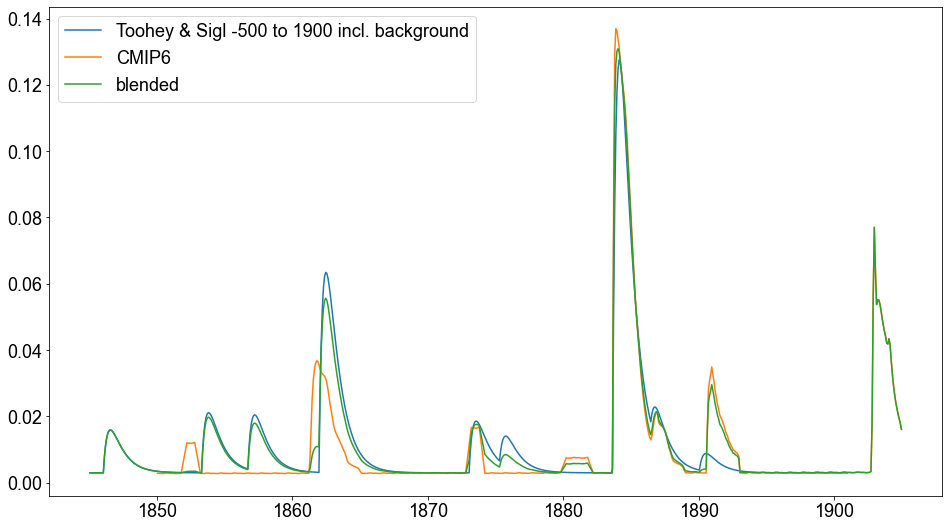

In [12]:
pl.plot(np.arange(1845+1/24,1901+1/24,1/12), aod_mt[28140:], label='Toohey & Sigl -500 to 1900 incl. background')
pl.plot(np.arange(1850+1/24,1905+1/24,1/12), aod_cmip6[:660], label='CMIP6')
pl.plot(np.arange(1845+1/24,1905+1/24,1/12), aod[28140:28860], label='blended')
pl.legend()

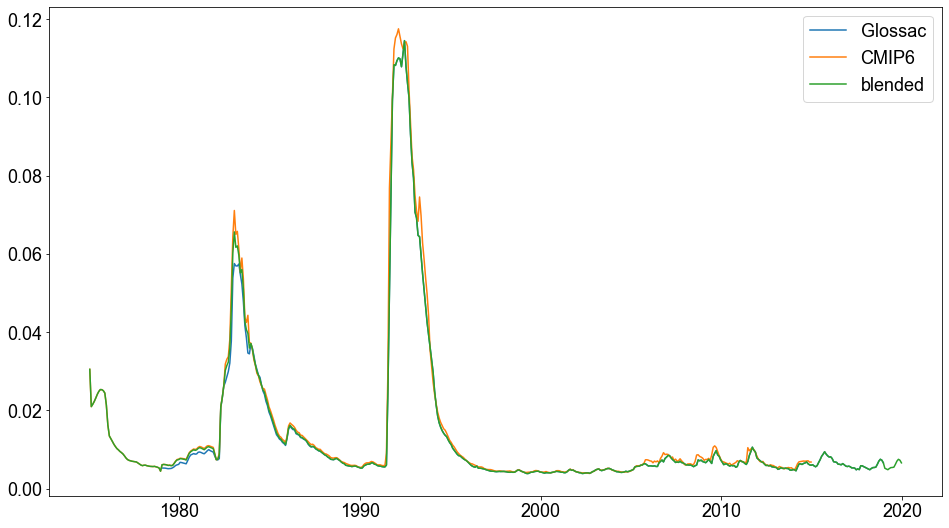

In [13]:
pl.plot(np.arange(1979+1/24,2019+1/24,1/12), aod_glossac, label='Glossac')
pl.plot(np.arange(1975+1/24,2015+1/24,1/12), aod_cmip6[-480:], label='CMIP6')
pl.plot(np.arange(1975+1/24,2020+1/24,1/12), aod[-540:], label='blended')
pl.legend()

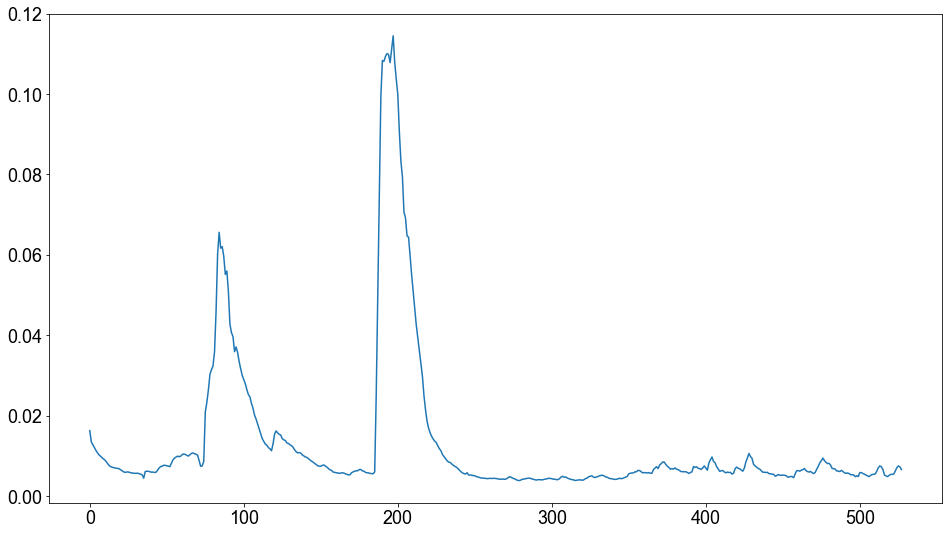

In [14]:
pl.plot(aod[-528:])

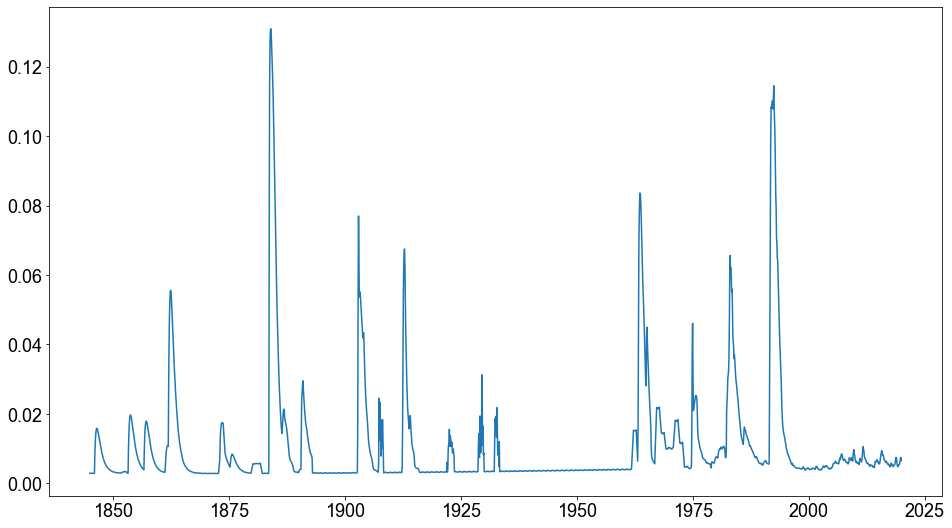

In [15]:
pl.plot(np.arange(1845+1/24,2020,1/12), aod[28140:])

In [16]:
volc_erf_minus20 = np.zeros((2520))
aod_2500yr_clim = np.zeros(12)
for i in range(12):
    aod_2500yr_clim[i] = np.mean(aod[i::12])
for i in range(2520):
    volc_erf_minus20[i] = np.mean(linear(aod[i*12:i*12+12] - aod_2500yr_clim, -20))
print (np.mean(volc_erf_minus20))

-2.8196140307940484e-18


In [17]:
aod[i*12:i*12+12]
i

2519

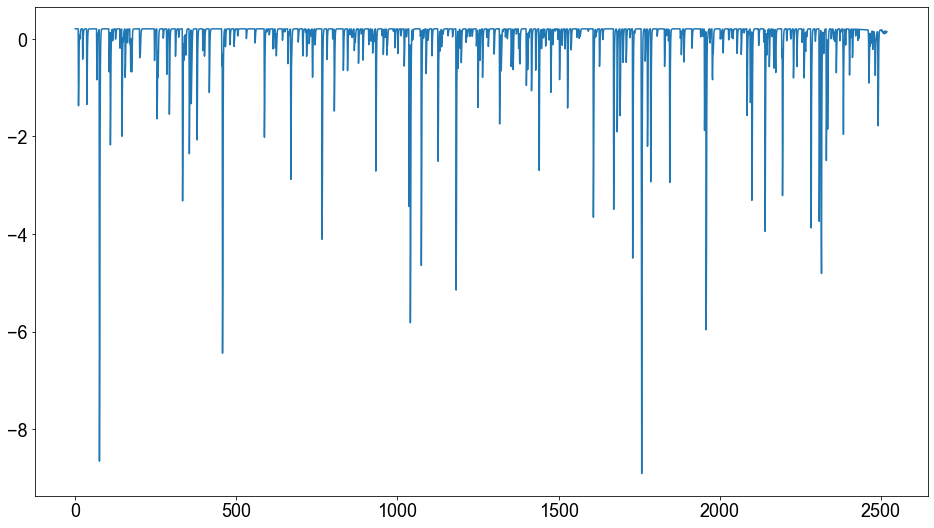

In [18]:
pl.plot(volc_erf_minus20)

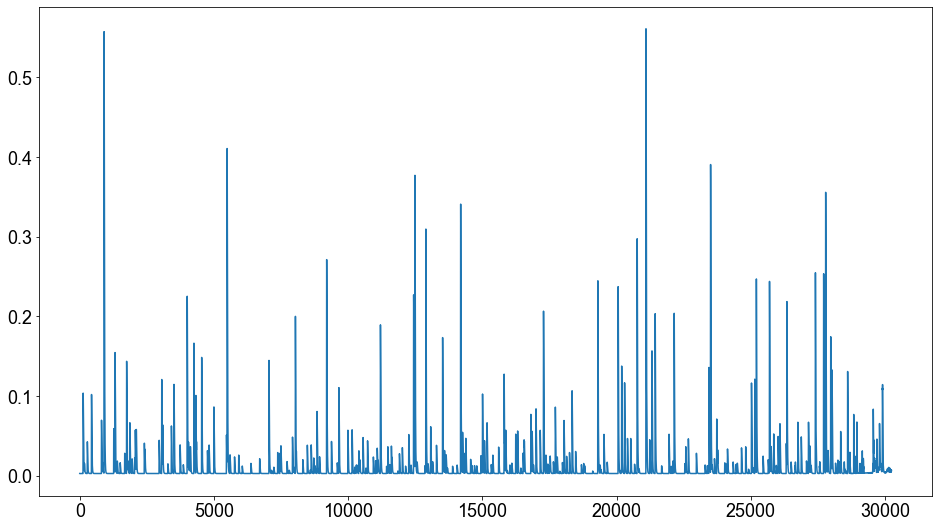

In [19]:
pl.plot(aod)

In [20]:
years = np.arange(-500,2020, dtype=int)
df = pd.DataFrame(data=volc_erf_minus20, index=years, columns=['volcanic_erf'])
df.index.name = 'year'
df.to_csv('../data_output/volcanic_erf.csv')
months = np.arange(-500+1/24,2020,1/12)
df = pd.DataFrame(data=aod, index=months, columns=['stratospheric_AOD'])
df.index.name = 'year'
df.to_csv('../data_output/volcanic_sAOD_monthly_-50001-201912.csv')

In [21]:
aod_annual_mean = np.zeros(2520)
for i in range(2520):
    aod_annual_mean[i] = np.mean(aod[i*12:i*12+12])

In [22]:
scipy.stats.linregress(aod_annual_mean, volc_erf_minus20)

LinregressResult(slope=-20.0, intercept=0.26520147170094216, rvalue=-1.0, pvalue=0.0, stderr=0.0)